
In computer science, a graph is a data structure consisting of two components: nodes (vertices) and edges.

A graph G can be defined as G = (V, E), where V is the set of nodes, and E are the edges between them.

If there are directional dependencies between nodes then edges are directed. If not, edges are undirected.

###What is the experimental protocol used and how was it carried out?: 

is to feature extract edges and nodes and labels from the original data and after finding out that the data is imbalanced, performing up-sampling and use GNN predict whether it's positive or not

## How did we tune hyper-parameters in the template? What is the search space


by choosing different message passing mechanisms (GGNN,RGCN,RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM)
or changing batch size (16, 64) or number or epochs (5, 15)

### what is the criteria to determine good/bad hyper-parameters?

if the accuracy on the validation set goes well then changing that hyperparameter is a good attitude and one of the reason to create a validation set is to tune hyper-parameters


### Define the problem.

the problem is a graph data that we try to understand and feature engineering it to get useful information that help us predict the positivity or negativity. a bioassay task for anticancer activity prediction, where each chemical compound is represented as a graph, with atoms representing nodes and bonds as edges.

### What is the input: 
graph data
 
### What is the output:
 classification output 0 or 1
 
### What data mining function is required:
 graph analysis using neural network. with such a complicated 
 data you need such a powerful tool to handle it 
 
###What could be the challenges: 
  to transform that graph to something neural network can understand and I have to understand first in order to conduct my analysis
  
### What is the impact:
choosing A chemical compound that is positive against non-small cell lung cancer, or negative otherwise

### What is an ideal solution:
is to come up with a model with high accuracy because this is a sensitive field and you don't want to miss aroud with people's life so with a small miss take might cause us lives and company's money and reputation


In [6]:
import numpy as np
from tqdm.notebook import tqdm

#this function split the samples with the $ sign then extract label
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):   # extract nodes from the dataset
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):   # extract edges from the dataset
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                

imbalance data

In [7]:
from sklearn.model_selection import train_test_split

training_set = read_sdf('train.sdf')
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [8]:
np.unique(np.array(training_set)[:,2].astype('int'), return_counts = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(array([0, 1]), array([20232,  1038]))

In [9]:
testing_set  = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

In [10]:
print(training_set[1])

(['Ga', 'O', 'O', 'O', 'O', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 1,  7],
       [ 2,  8],
       [ 3, 10],
       [ 4,  9],
       [ 5, 12],
       [ 6, 11],
       [ 7, 13],
       [ 7, 16],
       [ 8, 13],
       [ 8, 19],
       [ 9, 14],
       [ 9, 21],
       [10, 14],
       [10, 17],
       [11, 15],
       [11, 18],
       [12, 15],
       [12, 20]]), 0)


In [11]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
# colors represent each chemical compound
colors = cm.rainbow(np.linspace(0, 1, 50))

In [12]:
# using the data that we have extracted from the original data 
# to plot the graph's nodes and edges 
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

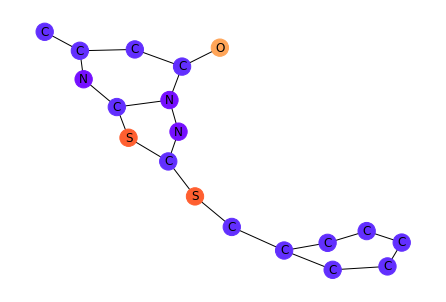

In [13]:
plt.clf()
visualize(training_set[20])

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [16]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 4 2 2 2 2 2 2 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0  18]
 [  1  19]
 [  2  20]
 [  3  21]
 [  4  29]
 [  5  28]
 [  6  29]
 [  6  30]
 [  7  28]
 [  7  31]
 [  8  10]
 [  8  14]
 [  8  16]
 [  9  11]
 [  9  15]
 [  9  17]
 [ 10  22]
 [ 10  24]
 [ 11  23]
 [ 11  25]
 [ 12  14]
 [ 12  26]
 [ 12  28]
 [ 13  15]
 [ 13  27]
 [ 13  29]
 [ 16  18]
 [ 17  19]
 [ 18  20]
 [ 19  21]
 [ 20  22]
 [ 21  23]
 [ 24  26]
 [ 25  27]
 [ 30  32]
 [ 31  32]
 [ 42  58]
 [ 42  71]
 [ 43  59]
 [ 43  70]
 [ 44  60]
 [ 44  67]
 [ 45  61]
 [ 45  66]
 [ 46  62]
 [ 46  68]
 [ 47  63]
 [ 47  69]
 [ 48  60]
 [ 49  61]
 [ 50  62]
 [ 51  63]
 [ 52  53]
 [ 52  55]
 [ 52  56]
 [ 52  64]
 [ 53  54]
 [ 53  57]
 [ 53  65

In [17]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

## Trial 1
thoughts and observations for trial 1: without upsampling and for "message_calculation_class", I have used GNN

 plan for trial 2: try to use different "message_calculation_class"

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
print(gen_batch(training_set))

<generator object gen_batch at 0x7fa5b5b629d0>


In [ ]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

1330/1330 [==============================] - 38s 26ms/step - loss: 0.2186 - auc: 0.5176 - val_loss: 0.1993 - val_auc: 0.6295
Epoch 2/5
1330/1330 [==============================] - 18s 14ms/step - loss: 0.1960 - auc: 0.6252 - val_loss: 0.2026 - val_auc: 0.6733
Epoch 3/5
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1907 - auc: 0.6633 - val_loss: 0.1929 - val_auc: 0.6963
Epoch 4/5
1330/1330 [==============================] - 18s 14ms/step - loss: 0.1861 - auc: 0.6800 - val_loss: 0.2072 - val_auc: 0.6619
Epoch 5/5
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1850 - auc: 0.6901 - val_loss: 0.1972 - val_auc: 0.6870


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission.csv')

## Trial 2:

thoughts and observations for trial 1: without upsampling and for "message_calculation_class", I have used GNN. this model gave me score 0.68817 on kaggle

plan for trial 2: try to use different "message_calculation_class", without upsampling

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.message_passing import GGNN

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'GGNN'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

1330/1330 [==============================] - 38s 25ms/step - loss: 0.1933 - auc: 0.6017 - val_loss: 0.1943 - val_auc: 0.6425
Epoch 2/5
1330/1330 [==============================] - 39s 30ms/step - loss: 0.1842 - auc: 0.6552 - val_loss: 0.1900 - val_auc: 0.6712
Epoch 3/5
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1831 - auc: 0.6607 - val_loss: 0.1904 - val_auc: 0.6911
Epoch 4/5
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1819 - auc: 0.6780 - val_loss: 0.1911 - val_auc: 0.6666
Epoch 5/5
1330/1330 [==============================] - 30s 23ms/step - loss: 0.1796 - auc: 0.6943 - val_loss: 0.1895 - val_auc: 0.6787


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_GGNN.csv')

## Trial 3:

thoughts and observations for trial 1: without upsampling and for "message_calculation_class", I have used GGNN. this model 
gave me higher from 0.68817 to 0.69699
plan for trial 3: try to use different "message_calculation_class", without upsampling

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.message_passing import GGNN

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'RGAT'
params['num_heads'] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

1330/1330 [==============================] - 44s 27ms/step - loss: 0.2250 - auc: 0.4970 - val_loss: 0.2153 - val_auc: 0.5885
Epoch 2/5
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1958 - auc: 0.6194 - val_loss: 0.1959 - val_auc: 0.6778
Epoch 3/5
1330/1330 [==============================] - 29s 22ms/step - loss: 0.1888 - auc: 0.6671 - val_loss: 0.1986 - val_auc: 0.6892
Epoch 4/5
1330/1330 [==============================] - 27s 21ms/step - loss: 0.1852 - auc: 0.6903 - val_loss: 0.1880 - val_auc: 0.7103
Epoch 5/5
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1834 - auc: 0.6982 - val_loss: 0.1830 - val_auc: 0.7143


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_RGAT.csv')

## Trial 4
thoughts and observations for trial 3: 0.71062, which is an improvement of your previous score of 0.69699

plan for trial 4: try to use different "message_calculation_class", without upsampling

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.message_passing import GGNN

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'RGIN'
params['num_aggr_MLP_hidden_layers'] = 0
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_13/StatefulPartitionedCall:0', description="created by layer 'gnn_13'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_49 (InputLayer)          [(None,)]            0           []      

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

1330/1330 [==============================] - 24s 15ms/step - loss: 0.2223 - auc: 0.5196 - val_loss: 0.2061 - val_auc: 0.6185
Epoch 2/5
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1977 - auc: 0.6199 - val_loss: 0.2025 - val_auc: 0.6404
Epoch 3/5
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1952 - auc: 0.6249 - val_loss: 0.1959 - val_auc: 0.6335
Epoch 4/5
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1953 - auc: 0.6343 - val_loss: 0.2489 - val_auc: 0.5679
Epoch 5/5
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1937 - auc: 0.6375 - val_loss: 0.1992 - val_auc: 0.6544


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_RGIN.csv')

## Trial 5:

thoughts and observations for trial 3: 0.68003
, which is worse than of your previous score of 0.71062

plan for trial 5: try to use different "message_calculation_class", without upsampling

In [ ]:
from tf2_gnn.layers.message_passing import GNN_FiLM

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.message_passing import GGNN

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'GNN_FiLM'
params['film_parameter_MLP_hidden_layers'] = 0
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_17/StatefulPartitionedCall:0', description="created by layer 'gnn_17'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_63 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_61 (InputLayer)          [(None,)]            0           []      

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount

1330/1330 [==============================] - 84s 18ms/step - loss: 0.2167 - auc: 0.5242 - val_loss: 0.1973 - val_auc: 0.6398
Epoch 2/5
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1886 - auc: 0.6671 - val_loss: 0.1842 - val_auc: 0.7430
Epoch 3/5
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1818 - auc: 0.7168 - val_loss: 0.2006 - val_auc: 0.7353
Epoch 4/5
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1814 - auc: 0.7209 - val_loss: 0.1826 - val_auc: 0.7498
Epoch 5/5
1330/1330 [==============================] - 23s 18ms/step - loss: 0.1839 - auc: 0.7165 - val_loss: 0.1856 - val_auc: 0.7423


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_GNN_FiLM.csv')

## Trial 6:

thoughts and observations for trial 3: 0.76200, which is an improvement of my best previous score of 0.71062

plan for trial 6: try to use different "message_calculation_class", without upsampling

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.message_passing import GGNN

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'GNN_Edge_MLP'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_18/StatefulPartitionedCall:0', description="created by layer 'gnn_18'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_10/SegmentMean:0', description="created by layer 'tf.math.segment_mean_10'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_64 (InputLayer)          [(None,)]            0           [] 

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/gnn__edge_mlp_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype

1330/1330 [==============================] - 33s 22ms/step - loss: 0.2255 - auc: 0.5103 - val_loss: 0.2253 - val_auc: 0.5912
Epoch 2/5
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1962 - auc: 0.6202 - val_loss: 0.1993 - val_auc: 0.6141
Epoch 3/5
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1930 - auc: 0.6439 - val_loss: 0.1971 - val_auc: 0.6438
Epoch 4/5
1330/1330 [==============================] - 20s 15ms/step - loss: 0.1905 - auc: 0.6571 - val_loss: 0.1983 - val_auc: 0.6701
Epoch 5/5
1330/1330 [==============================] - 19s 14ms/step - loss: 0.1881 - auc: 0.6692 - val_loss: 0.1946 - val_auc: 0.6994


In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_GNN_Edge_MLP.csv')

## Trial 7

thoughts and observations for trial 8: 0.79760  , which is better than of your previous score of 0.71660

plan for trial 8: try to use different "message_calculation_class", upsampling

In [18]:
train = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [20]:
zero_class=[]
one_class=[]
for i in range(len(train)):
    if train[i][2]==0:
        zero_class.append(train[i])
    else:
        one_class.append(train[i])

In [21]:
from sklearn.utils import resample
one_upsample = resample(one_class,
                        replace=True,
                        n_samples=len(zero_class),
                        random_state=42)

In [22]:
training_balanced = [*zero_class,*one_upsample]

In [23]:
training_balanced, validation_balanced = train_test_split(training_balanced, test_size=0.15)

In [24]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                      

In [25]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [28]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_balanced) / batch_size)
num_batchs_validation = math.ceil(len(validation_balanced) / batch_size)

model.fit(
    gen_batch(
        training_balanced, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_balanced, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

2530/2530 [==============================] - 59s 22ms/step - loss: 0.6259 - auc: 0.7065 - val_loss: 0.6020 - val_auc: 0.7366
Epoch 2/5
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5959 - auc: 0.7443 - val_loss: 0.5778 - val_auc: 0.7688
Epoch 3/5
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5769 - auc: 0.7687 - val_loss: 0.5560 - val_auc: 0.7876
Epoch 4/5
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5586 - auc: 0.7890 - val_loss: 0.5485 - val_auc: 0.8000
Epoch 5/5
2530/2530 [==============================] - 58s 23ms/step - loss: 0.5471 - auc: 0.8000 - val_loss: 0.5402 - val_auc: 0.8143


In [29]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [30]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_balanced.csv')

## Trial 8

thoughts and observations for trial 7:  0.79760 , which is better than of your previous score of 0.71062

plan for trial 8: try to use different "message_calculation_class", upsampling

In [31]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'GGNN'
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

In [32]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [33]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_balanced) / batch_size)
num_batchs_validation = math.ceil(len(validation_balanced) / batch_size)

model.fit(
    gen_batch(
        training_balanced, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_balanced, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

2530/2530 [==============================] - 107s 40ms/step - loss: 0.6271 - auc: 0.6973 - val_loss: 0.6056 - val_auc: 0.7400
Epoch 2/5
2530/2530 [==============================] - 99s 39ms/step - loss: 0.5696 - auc: 0.7746 - val_loss: 0.5416 - val_auc: 0.8034
Epoch 3/5
2530/2530 [==============================] - 99s 39ms/step - loss: 0.5401 - auc: 0.8033 - val_loss: 0.5187 - val_auc: 0.8237
Epoch 4/5
2530/2530 [==============================] - 84s 33ms/step - loss: 0.5112 - auc: 0.8282 - val_loss: 0.4893 - val_auc: 0.8468
Epoch 5/5
2530/2530 [==============================] - 86s 34ms/step - loss: 0.4814 - auc: 0.8506 - val_loss: 0.4560 - val_auc: 0.8677


In [34]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [35]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_balanced_GGNN.csv')

## Trial 9

thoughts and observations for trial 8: 0.83539 , which is better than of your previous score of 0.79760

plan for trial 8: try to use different "message_calculation_class", upsampling

In [36]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'RGAT'
params['num_heads'] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

In [37]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [38]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_balanced) / batch_size)
num_batchs_validation = math.ceil(len(validation_balanced) / batch_size)

model.fit(
    gen_batch(
        training_balanced, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_balanced, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2530/2530 [==============================] - 90s 32ms/step - loss: 0.6227 - auc: 0.7122 - val_loss: 0.6188 - val_auc: 0.7335
Epoch 2/5
2530/2530 [==============================] - 96s 38ms/step - loss: 0.5925 - auc: 0.7521 - val_loss: 0.5869 - val_auc: 0.7591
Epoch 3/5
2530/2530 [==============================] - 71s 28ms/step - loss: 0.5787 - auc: 0.7688 - val_loss: 0.5566 - val_auc: 0.7937
Epoch 4/5
2530/2530 [==============================] - 71s 28ms/step - loss: 0.5621 - auc: 0.7864 - val_loss: 0.5477 - val_auc: 0.8001
Epoch 5/5
2530/2530 [==============================] - 72s 28ms/step - loss: 0.5487 - auc: 0.7994 - val_loss: 0.5294 - val_auc: 0.8169


In [39]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [40]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_balanced_RGAT.csv')

## Trial 10

thoughts and observations for trial 8: 0.79613 , which is worse than of your previous score of 0.83539

plan for trial 8: try to use different "message_calculation_class", upsampling

In [41]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
#params("message_calculation_class")
params['message_calculation_class'] = 'GNN_FiLM'
params['film_parameter_MLP_hidden_layers'] = 0
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [42]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [43]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_balanced) / batch_size)
num_batchs_validation = math.ceil(len(validation_balanced) / batch_size)

model.fit(
    gen_batch(
        training_balanced, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_balanced, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/gnn__fi_lm_2/embedding_lookup_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount

2530/2530 [==============================] - 67s 25ms/step - loss: 0.5926 - auc: 0.7495 - val_loss: 0.5671 - val_auc: 0.7924
Epoch 2/5
2530/2530 [==============================] - 60s 24ms/step - loss: 0.5424 - auc: 0.8035 - val_loss: 0.5463 - val_auc: 0.8271
Epoch 3/5
2530/2530 [==============================] - 60s 24ms/step - loss: 0.5101 - auc: 0.8309 - val_loss: 0.5053 - val_auc: 0.8406
Epoch 4/5
2530/2530 [==============================] - 61s 24ms/step - loss: 0.4847 - auc: 0.8492 - val_loss: 0.4651 - val_auc: 0.8636
Epoch 5/5
2530/2530 [==============================] - 60s 24ms/step - loss: 0.4565 - auc: 0.8681 - val_loss: 0.4338 - val_auc: 0.8822


In [44]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [45]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_balanced_GNN-FiLM.csv')

0.84947 which is even better that the best one of the previous models

##GCN

In [5]:
!pip install stellargraph

     |████████████████████████████████| 435 kB 10.5 MB/s 
     |████████████████████████████████| 462 kB 33.0 MB/s 


In [6]:
from stellargraph.layer.gcn import GraphConvolution, GatherIndices

# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5


#Questions

## describe the format of the input file (sdf file).

the data contains a bunch of numbers and characters where characters represent nodes or components of the drug for example O-> oxygen, N ->neutrogena and so on. after each sample there is a number either 1 or -1 which is the label. we extract the links or edges that connect nodes with each others

### What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

embeded, edge,node2graph,num_graph

embedded: represent the index of each feature or node instead of doing one-hot encoding

edge : is the link between the nodes

node2graph: order of the sample repetted with number of samples

num_graph: number of samples, which came from the maximum of each array 

dim

embedded : 20
edge: 2
node2graph: 1

### For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

gnn_out take the input of gnn which is embeded data, edges , node2graph and num_graph beside parameters/ hyperparameters to apply gnn on them 

avg : use that gnn_out as an input to the segment_avg and node2graph as an index

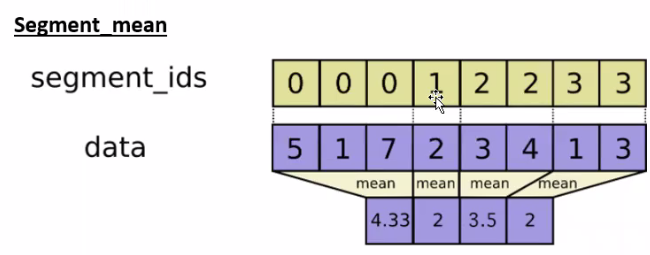

### What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

reduce_mean: Computes the mean of elements across dimensions of a tensor

segment_mean: it compute the mean over each the segment 

pred: has a node represent the positive case or negative case and with sigmoid as an activation so if the output of the avg layer larger than .5 pred predict positive 1 and if not pred predict negative 0 

### What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

Compressing a trained deep GCN into a compact GCN is of great importance for implementing the model to environments such as mobile or embedded systems, which have limited computing resources. almost none